### Uncomment if running in Colab

In [1]:
# !pip install toughio

In [2]:
# setup enviornment for interactive plotting
# !apt-get install -qq xvfb
# !pip install pyvista panel -q

In [3]:
# import os
# os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
# os.environ['DISPLAY'] = ':99'

In [4]:
# import panel as pn
# pn.extension('vtk')

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# import sys
# !{sys.executable} -m numpy.f2py --quiet -c '/content/drive/MyDrive/IRP/shape_functions (31).f90' -m shape_functions  --fcompiler=gnu95 --f90flags=-O3
# !{sys.executable} -m numpy.f2py --quiet -c '/content/drive/MyDrive/IRP/space_filling_decomp_new.f90' -m space_filling_curves  --fcompiler=gnu95 --f90flags=-O3

In [7]:
#!python3 -m numpy.f2py -c --quiet 'shape_functions (31).f90' -m shape_functions

WARN: Could not locate executable armflang


In [8]:
# Regular libraries
import math
import numpy as np
import copy
import time
import sys

# AI libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

# FEM and SFC libraries
import shape_functions as sf
import space_filling_curves as sfc

# Mesh libraries
import pyvista
import toughio

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# check if running on gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [9]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=8)

# Initialize Mesh

In [10]:
nx, ny = 32,32

In [11]:
dx = [1]*(nx-1)
dy = [1]*(ny-1)
mesh = toughio.meshmaker.structured_grid(dx, dy, origin=(0,0))

# FEM discretization using shape_functions module

In [12]:
# Rearrange so it would work in the shape_functions module.
# Basically, put the last node in second position.
temp = copy.deepcopy(mesh.cells[0][1][:,-1]) 
mesh.cells[0][1][:,-1] = mesh.cells[0][1][:,2]
mesh.cells[0][1][:,2] = mesh.cells[0][1][:,1]
mesh.cells[0][1][:,1] = temp

In [13]:
nonods = mesh.n_points
u = np.array([[0]*nonods, [0]*nonods]).astype(float)
k = np.array([1] * nonods).astype(float)
sig = np.array([0] * nonods).astype(float)
s = np.array([0] * nonods).astype(float)
nloc = 4
ndim=2
totele = mesh.n_cells
ndglno = mesh.cells[0][1].flatten() + 1
alpha = 1/3
relax_keep_off = 0.5
nfilt_size_sfc= 11
scale_matrices = True # scale sfc and original meshes by ml or not
lvl_start_jac = 1 # level to start jacobi iteration, default is 1
#ntime=10

In [14]:
# Point source in middle of domain
s[int(nonods/2)] = 1

In [15]:
# Get the global node number for each node per FE 
x_all = [[], []]
for node in ndglno:
    x_all[0].append(mesh.points[node-1][1])
    x_all[1].append(mesh.points[node-1][0])

In [16]:
# create the adjacency matrix to store connections
adjacency_matrix = torch.eye(nonods)

# populate the connections with a one 
for element in mesh.cells[0][1]:
    for i in element:
        for j in element:
            if adjacency_matrix[i][j] != 1:
                adjacency_matrix[i][j] = 1

In [17]:
# Get the indices for the nonzeros(nnzs) in the adjacency matrix
a_indices = adjacency_matrix.nonzero().t().contiguous()

In [18]:
# Get the cola and fina lists for the sparse matrix
cola = a_indices[1] + 1
fina = np.zeros(nonods+1)
fina_value = 1
i=0

for occurrence in torch.bincount(a_indices[0]):
    fina[i] = fina_value
    fina_value += occurrence.item()
    i += 1
    
fina[-1] = fina_value
fina = fina.astype(int)

In [19]:
# Get the number of nnzs
ncola = cola.shape[0]

In [20]:
a, b, ml = sf.get_fe_matrix_eqn(x_all= x_all, u=u, k=k, sig=sig, s=s, fina=fina, cola=cola, ncola=ncola, ndglno=ndglno, nonods=nonods, totele=totele,nloc=nloc, ndim=ndim, ele_type=1)

 going into get_shape_funs_with_faces
 just about to allocate
 nloc, sngi, ngi, ndim, nface,max_face_list_no:           4           3           9           2           4           2
 npoly,ele_type:           1           1
 here 1
 here 2
 here 3
 get_shape_funs
 going into SPECTR
 here 1.1
 ndgi,ndnod,nmdnod:           3           2           2
 here 1.2
 here 1.3
 here 1.4
 here 1.5
 here 1.6 d2= T
 just leaving spectr
 out of SPECTR
 going into SPECTR
 just leaving spectr
 out of SPECTR
 sNGI,sNLOC_temp,ndim,IPOLY,IQADRA:           3           2           2           1           1
 snlx(:,idim,siloc):           1           1 -0.500000000     -0.500000000     -0.500000000    
 snlx(:,idim,siloc):           1           2  0.500000000      0.500000000      0.500000000    
 sWEIGHT:  0.555555582      0.888888896      0.555555582    
 sndim:           1
 finished get_shape_funs
 sn:  0.887298346      0.500000000      0.112701654      0.112701654      0.500000000      0.887298346    
 snl

# Remove boundary nodes from a, b and ml

In [21]:
def get_boundary_nonboundary_nodes(mesh=mesh): 
    ''' Function to get boundary and non-boundary nodes of the mesh'''
    
    boundary_nodes = []
    non_boundary_nodes = []
    
    x_min = mesh.points.transpose()[0].min()
    x_max = mesh.points.transpose()[0].max()
    y_min = mesh.points.transpose()[1].min()
    y_max = mesh.points.transpose()[1].max()
    for i in range(nonods):
        if mesh.points.transpose()[0][i] == x_min or mesh.points.transpose()[0][i] == x_max or mesh.points.transpose()[1][i] == y_min or mesh.points.transpose()[1][i] == y_max:
            boundary_nodes.append(i)
        else:
            non_boundary_nodes.append(i)
    return boundary_nodes, non_boundary_nodes

In [22]:
# Get boundary and non-boundary nodes
boundary_nodes = get_boundary_nonboundary_nodes()[0]
non_boundary_nodes = get_boundary_nonboundary_nodes()[1]

In [23]:
# First, get a matrix and convert to sparse
a_sparse = torch.sparse_coo_tensor(a_indices, a, (nonods, nonods))

In [24]:
# Remove all boundary nodes from a, b add ml
new_a = np.delete(np.delete(np.array(a_sparse.to_dense()), boundary_nodes, 0), boundary_nodes, 1)
new_b = np.delete(b, boundary_nodes, 0)
new_ml = np.delete(ml, boundary_nodes, 0)


# Scale a, b, ml for original mesh

In [25]:
# Get new number of nodes after removing boundary nodes
new_nonods = new_a.shape[0]

In [26]:
# Convert new_a to sparse
new_a_indices = np.array(new_a.nonzero())
values_new_a = new_a[new_a_indices[0], new_a_indices[1]]
#new_a_sparse = torch.new_a.nonzero()
new_a_sparse = torch.sparse_coo_tensor(new_a_indices, values_new_a, (new_nonods,new_nonods))

In [27]:
# convert new ml to sparse and get ml_inv as well
indices_ml_new = torch.zeros((2,new_nonods))
for i in range(new_nonods):
    indices_ml_new[0][i] = i
    indices_ml_new[1][i] = i

indices_ml_new = indices_ml_new.int()

new_ml_sparse = torch.sparse_coo_tensor(indices_ml_new, new_ml, (new_nonods,new_nonods))

new_ml_sparse_inv = torch.sparse_coo_tensor(indices_ml_new, 1/new_ml, (new_nonods,new_nonods))

In [28]:
# simply divide new_a_sparse and new_b by new_ml
#if scale_matrices == True:
new_a_sparse = torch.sparse.mm(new_ml_sparse_inv, new_a_sparse)
new_b = new_b/new_ml

# Get both SFC matrices for all levels

In [29]:
# Get new fina and cola values
new_a_indices = torch.Tensor(new_a).nonzero().t()

cola = new_a_indices[1] + 1
fina = np.zeros(new_nonods+1)
fina_value = 1
i=0

for occurrence in torch.bincount(new_a_indices[0]):
    fina[i] = fina_value
    fina_value += occurrence.item()
    i += 1
fina[-1] = fina_value
fina = fina.astype(int)

ncola = cola.shape[0]

In [30]:
# SFCs variables
ncurve = 2 # number of sfcs
graph_trim = -10  # has always been set at -10
starting_node = 0

In [31]:
whichd, space_filling_curve_numbering = sfc.ncurve_python_subdomain_space_filling_curve(cola, fina, starting_node, graph_trim, ncurve, new_nonods, ncola)

In [32]:
N = len(space_filling_curve_numbering)
inverse_numbering = np.zeros((N, ncurve), dtype=int)

inverse_numbering[:, 0] = np.argsort(space_filling_curve_numbering[:, 0])
inverse_numbering[:, 1] = np.argsort(space_filling_curve_numbering[:, 1])

In [33]:
max_nlevel = sf.calculate_nlevel_sfc(new_nonods) + 1
max_nonods_sfc_all_grids = 4*new_nonods

In [34]:
a_sfc_1, b_sfc_1, ml_sfc_1, fin_sfc_nonods, nonods_sfc_all_grids, nlevel = sf.best_sfc_mapping_to_sfc_matrix_n(a=values_new_a, b=new_b, ml=new_ml, fina=fina, cola=cola, sfc_node_ordering=space_filling_curve_numbering[:, 0], ncola=ncola, nonods=new_nonods, max_nonods_sfc_all_grids=max_nonods_sfc_all_grids, max_nlevel=max_nlevel, relax_keep_off=relax_keep_off, nfilt_size_sfc=nfilt_size_sfc)
a_sfc_2, b_sfc_2, ml_sfc_2, _, _, _ = sf.best_sfc_mapping_to_sfc_matrix_n(a=values_new_a, b=new_b, ml=new_ml, fina=fina, cola=cola, sfc_node_ordering=space_filling_curve_numbering[:, 1], ncola=ncola, nonods=new_nonods, max_nonods_sfc_all_grids=max_nonods_sfc_all_grids, max_nlevel=max_nlevel, relax_keep_off=relax_keep_off, nfilt_size_sfc=nfilt_size_sfc)

 2-just inside best_sfc_mapping_to_sfc_matrix_n
 here 2
 just leaving best_sfc_mapping_to_sfc_matrix_n
 2-just inside best_sfc_mapping_to_sfc_matrix_n
 here 2
 just leaving best_sfc_mapping_to_sfc_matrix_n


In [35]:
#Store in lists for access
a_sfc = [torch.Tensor(a_sfc_1), torch.Tensor(a_sfc_2)]
b_sfc = [torch.Tensor(b_sfc_1), torch.Tensor(b_sfc_2)]
ml_sfc = [torch.Tensor(ml_sfc_1), torch.Tensor(ml_sfc_2)]

# Get SFC matrices and vectors in each level

In [36]:
def get_a_ml_b(level, curve, fin_sfc_nonods=fin_sfc_nonods, a_sfc=a_sfc, b_sfc=b_sfc, ml_sfc=ml_sfc, nfilt_size_sfc=nfilt_size_sfc, scale_matrices=scale_matrices):
    '''Function to get a, b ml and ml inverse in sfc ordering for each level as sparse matrices
    
        Input
        ---------------------------------------------------------------------------------------------
        level: Level to get sfc ordering starting from 0 as the first
        curve: the sfc curve to consider
        fin_sfc_nonods: List containing the starting index in a_sfc of each level
        a_sfc = list containing a_sfcs in different SFC ordering
        b_sfc = list containing b_sfcs in different SFC ordering
        ml_sfc = list containing ml_sfcs in different SFC ordering
        
        Output
        ---------------------------------------------------------------------------------------------
        a_sfc_level_sparse: a matrix in SFC ordering for specified level
        b_sfc_level: b vector in SFC ordering for specified level
        diagonal: Diagonal values in a_sfc_level_sparse
        nonods: Number of nodes in specified level
    '''
    # level 0 is the highest level
    # level nlevel-1 is the lowest level
    # subtracting 1 because fortran indexes from 1 but python indexes from 0
    start_index = fin_sfc_nonods[level] - 1
    end_index = fin_sfc_nonods[level + 1] - 1
    
    nonods = end_index - start_index
    
    #---------------------------- get a_sfc_level-------------------------------#
    # find the diag index
    diag_index = int(nfilt_size_sfc/2)
    
    # main diagonal 
    diagonal = a_sfc[curve][diag_index][start_index:end_index]
    a_sfc_level = torch.diag(diagonal)
    
    #------------ accounting for bigger filter sizes -----------------#
    for i in range(nfilt_size_sfc):
        if i < diag_index:
            if start_index+(diag_index-i) > end_index:
                continue
            a_sfc_level += torch.diag(a_sfc[curve][i][start_index+(diag_index-i):end_index], diagonal=i-diag_index)
        elif i > diag_index:
            if start_index > end_index-(i-diag_index):
                continue
            a_sfc_level += torch.diag(a_sfc[curve][i][start_index:end_index-(i-diag_index)], diagonal=i-diag_index)
        
    
    #----------- convert a_sfc_level to sparse --------------#
    # get indices
    a_sfc_level_indices = a_sfc_level.nonzero().t()
    # get values
    a_sfc_level_values = a_sfc_level[a_sfc_level_indices[0], a_sfc_level_indices[1]]
    
    a_sfc_level_sparse = torch.sparse_coo_tensor(a_sfc_level_indices, a_sfc_level_values, (nonods, nonods))
    
    
    
    #-----------get ml_sfc_level and its inverse and convert  to sparse ----------#
    ml_sfc_level = ml_sfc[curve][start_index:end_index]

    #indices
    ml_sfc_level_indices = torch.zeros((2,nonods))
    ml_sfc_level_indices[0] = torch.Tensor([i for i in range(nonods)])
    ml_sfc_level_indices[1] = ml_sfc_level_indices[0]
    ml_sfc_level_indices = ml_sfc_level_indices.int()

    # convert to sparse
    ml_sfc_level_sparse = torch.sparse_coo_tensor(ml_sfc_level_indices, ml_sfc_level, (nonods, nonods))
    # inverse
    ml_sfc_level_sparse_inv = torch.sparse_coo_tensor(ml_sfc_level_indices, 1/ml_sfc_level, (nonods, nonods))
    
    
    #---------------------------- get b_sfc -----------------------------------#
    b_sfc_level = b_sfc[curve][start_index:end_index]
    

    #----------------------- Divide each one by ml_sfc_level ------------------#
    if scale_matrices == True:
        a_sfc_level_sparse = torch.sparse.mm(ml_sfc_level_sparse_inv, a_sfc_level_sparse)
        b_sfc_level = b_sfc_level/ml_sfc_level
    
    #  ml_sfc_level_sparse, ml_sfc_level_sparse_inv,
    return a_sfc_level_sparse, b_sfc_level, diagonal, nonods

In [37]:
# variables_first_sfc[0][0] - a_sfc for level 0 in first sfc
# variables_first_sfc[0][1] - b_sfc for level 0 in first sfc
# variables_first_sfc[0][2] - diagonal for level 0 in first sfc
# variables_first_sfc[0][3] - nonods for level 0 in first sfc

levels = [level for level in range(nlevel)]

# ------------------------------- FIRST CURVE -----------------------------#
iteration_0 = [0]*nlevel
variables_first_sfc = list(map(get_a_ml_b, levels, iteration_0))


# ------------------------------- SECOND CURVE -----------------------------#
iteration_1 = [1]*nlevel
variables_second_sfc = list(map(get_a_ml_b, levels, iteration_1))

# save in list/tensor (which is faster?)
variables_sfc = [variables_first_sfc, variables_second_sfc]

# Jacobi Matrix

In [38]:
class CNN1D_A(nn.Module):
    def __init__(self):
        super(CNN1D_A, self).__init__()
    
    def forward(self, level, curve, Tn, variables_sfc=variables_sfc):
        '''Convolutional Neural Network to multiply the scalar field by the scaled FEM matrix
        
        Input
        ----------------------------------------------------------------------------------------------
        level: Grid level of the agglomerated mesh. Level 0 is the finest grid and level nlevel-1 is the lowest grid with nonods=1
        curve: The SFC curve to consider; 0 or 1
        Tn: The current scalar field
        variables_sfc: List that contains the a, b, diagonal weights in a and nonods in specified level for both SFCs
        
        Output
        ----------------------------------------------------------------------------------------------
        Tn_1: The next solution of the scalar field
        
        '''
        # get a_sfc and ml_sfc for this level and curve
        a_sfc_sparse, b_sfc_level, diag_weights, nonods_level = variables_sfc[curve][level]
        
        # timestep
        Tn_1 = torch.sparse.mm(a_sfc_sparse, Tn.view(nonods_level,1))
            
        return Tn_1.view(1,1,nonods_level), diag_weights.view(1,1,nonods_level)

# Check the agglomeration of the mesh

In [39]:
nodes_per_level = [fin_sfc_nonods[i] - fin_sfc_nonods[i-1] for i in range(1, nlevel+1)]

In [40]:
nlevel, nodes_per_level

(11, [900, 450, 225, 113, 57, 29, 15, 8, 4, 2, 1])

# Restrictor

In [41]:
# Two restrictors will be used
# for levels that can be divided by 2
CNN1D_res = nn.Conv1d(1, 1, kernel_size=2, stride=2, padding='valid', bias=False) 
filter_ = torch.Tensor([[0.5, 0.5]]).float().view(1, 1, 2) 
CNN1D_res.weight.data = filter_

# for levels that cannot
CNN1D_res_odd = nn.Conv1d(1, 1, kernel_size=2, stride=2, padding=0, bias=False)
filter_odd = torch.Tensor([[0.5, 0.5]]).float().view(1, 1, 2) 
CNN1D_res_odd.weight.data = filter_odd

In [42]:
# if theres an odd number in the agglomeration of the mesh, use CNN1D_res_odd through out, if not, use CNN1D_res
odd_meshes = False

for i in range(nlevel-1):
    if nodes_per_level[i]%2 == 1:
        odd_meshes = True
        break

In [43]:
odd_meshes

True

# Prolongator

In [44]:
CNN1D_prol = nn.Upsample(scale_factor=2)

# Initial Condition

In [45]:
T = np.zeros([nx,ny])
gamma = 40
# initialise t:
x0 = 0 
y0 = -50
# x and y are vectors of the same shape (1, nx)
x_ = np.zeros([1,nx])
y_ = np.zeros([1,nx])
for ii in range(nx):
    x_[0][ii] = -150 + 300/nx*ii
    y_[0][ii] = -150 + 300/nx*ii   
    
# dirichlet boundary conditions where the boundaries remain zero
for i in range(1,nx-1):
    for j in range(1,ny-1):
        temp1 = -((x_[0][i] - x0)**2 + (y_[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)
        
input_shape = (1,nx,ny,1)

values = np.zeros(input_shape)

# # generate Gaussian with a blob
# for i in range(nx):
#     for j in range(ny):
#         values[0][i][j][0] = T[i][j] #+ Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5
        
# generate square dist - for 128x128
# for i in range(20):
#     for j in range(20):
#         values[0][i+75][j+70][0] = values[0][i+75][j+70][0] + 1

#generate square dist - for 64x64
# for i in range(20):
#     for j in range(20):
#         values[0][i+40][j+35][0] = values[0][i+40][j+35][0] + 1

# generate square dist - for 32x32
for i in range(5):
    for j in range(5):
        values[0][i+10][j+15][0] = values[0][i+10][j+15][0] + 1
        
        
values_ = torch.Tensor(values).view(nonods,1)

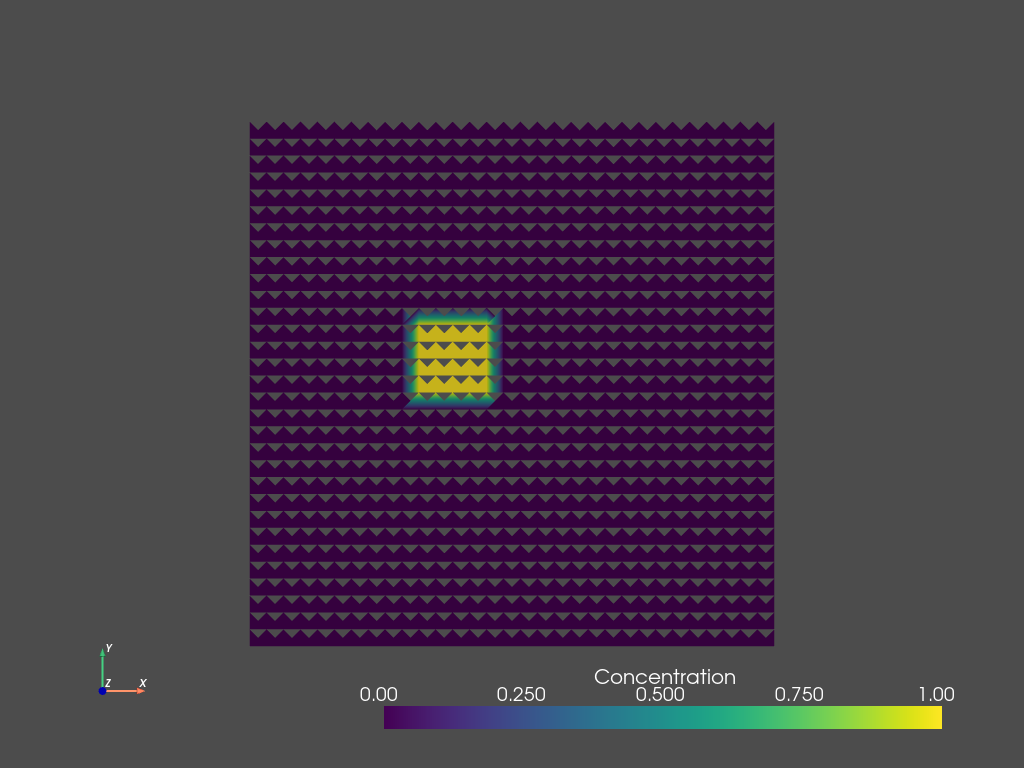

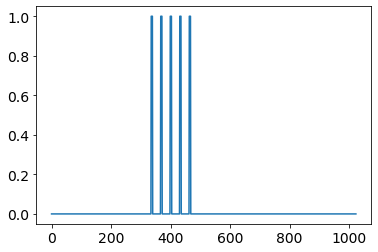

In [46]:
#pn.extension('vtk') 
# New plot
mesh.point_data = {'Concentration': values_}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')
plt.plot(values_[:])

In [47]:
new_values = torch.Tensor(np.delete(values_, boundary_nodes, 0)).view(1,1,new_nonods)

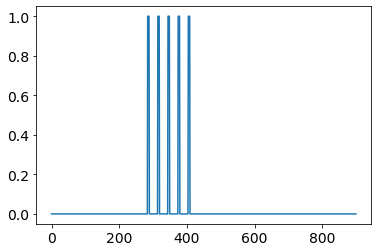

In [48]:
plt.plot(new_values[0,0,:])

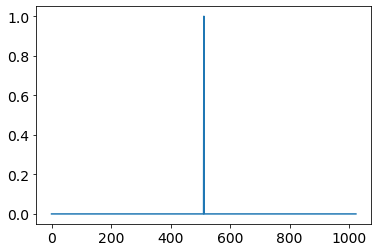

In [49]:
plt.plot(s[:])

# Multigrid with skipping layer

In [50]:
# Convert b to tensor and reshape
new_b = torch.Tensor(new_b).view(1,1,new_nonods)

In [51]:
start = time.time()          
#b = Tn_sfc            # only for one time step
multi_itr = 100        # multigrid iteration

# List to store w for each iteration
# results_to_csv = np.zeros((multi_itr,2))


j_itr = 1             # jacobi iteration 
ntime = 1             # number of timesteps
with torch.no_grad():
    
    model = CNN1D_A().to(device)
    
    for multi_grid in range(multi_itr):
        
      # for each multigrid iteration, you alternate between two sfcs
      for curve in range(ncurve):
        # initialize w
        w = torch.zeros([1,1,1])

# --------- Calculate Residual based on initial guess ---------------------------------------------------------------------------------- 
        r = new_b - (torch.sparse.mm(new_a_sparse, new_values.view(new_nonods,1))).view(1,1,new_nonods)
    
        # Map residual to sfc ordering
        r = torch.Tensor([r[0][0][i] for i in inverse_numbering[:, curve]]).view(1,1,new_nonods)
          
# --------------------------------------------------------------------------------------------------------------------------------------  
# --------- Interpolate Residual from finer to coaser mesh ----------------------------------------------------------------------------- 
        r_s = []
    
        #append residual for finest mesh - initial residual
        r_s.append(r)
          
        if odd_meshes == True:
            for i in range(1, nlevel):            
                r = F.pad(r, (0,1))
                r = CNN1D_res_odd(r)
                r_s.append(r)
        else:
            for i in range(1, nlevel):    
                r = CNN1D_res(r)
                r_s.append(r)

# --------------------------------------------------------------------------------------------------------------------------------------      

# --------- Interpolate Residual from coaser to finer mesh -----------------------------------------------------------------------------
        # level before iteration, not iteration before level
        for i in reversed(range(lvl_start_jac, nlevel)): # Eg, 14,13,12...1. Do not include the finest level
          for Jacobi in range(j_itr):
            w = w - alpha*(model(i, curve, w)[0]/model(i, curve, w)[1]) + alpha*(r_s[i]/model(i, curve, w)[1])
            if i != 0:
                CNN1D_prol_odd = nn.Upsample(scale_factor=nodes_per_level[i-1]/nodes_per_level[i])
                w = CNN1D_prol_odd(w)

        # Map w to original order
        w = torch.Tensor([w[0][0][i-1] for i in space_filling_curve_numbering[:, curve]]).view(1,1,new_nonods)
        
        # Put r_s[0] in original order as well
        r_s[0] = torch.Tensor([r_s[0][0][0][i-1] for i in space_filling_curve_numbering[:, curve]]).view(1,1,new_nonods)
        

#------Perform Jacobi relaxation on finest mesh using original residual -----------------------------------------------------------
        A_ = (torch.sparse.mm(new_a_sparse, w.view(new_nonods,1))).view(1,1,new_nonods)
        d = torch.Tensor([new_a_sparse[i][i].item() for i in range(new_nonods)]).view(1,1,new_nonods)
        w = w - alpha*(A_/d) + alpha*(r_s[0]/d)
       
        # Then add w to new_values
        new_values = new_values + w
        
# -------------------------------------------------------------------------------------------------------------------------------------- 
# -------------------------------------------------------------------------------------------------------------------------------------- 
      # Save result to csv
      # results_to_csv[multi_grid][0] = int(multi_grid)
      # results_to_csv[multi_grid][1] = w[0,0,:].max()
      # np.savetxt("32_structured_corrections.csv", results_to_csv, delimiter=",")
        

end = time.time()
print('Computational time(s):',(end-start))
print('Time steps:', ntime)
print('Multigrid iterations:', multi_itr)
print('Jacobi iterations:', j_itr)

Computational time(s): 8.491032361984253
Time steps: 1
Multigrid iterations: 100
Jacobi iterations: 1


# Residuals

([<matplotlib.lines.Line2D at 0x7f51604ce910>], tensor(-8.6904e-07))

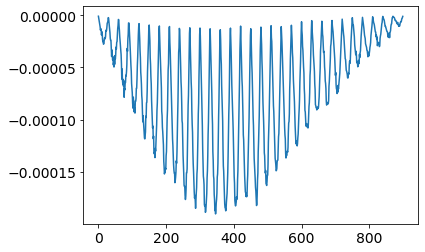

In [52]:
plt.plot(w[0,0,:]), w[0,0,:].max()

# Result

In [53]:
combined_values = torch.zeros(nonods)
for i in range(new_nonods):
    non_boundary_node = non_boundary_nodes[i]
    combined_values[non_boundary_node] = new_values.view(new_nonods)[i]

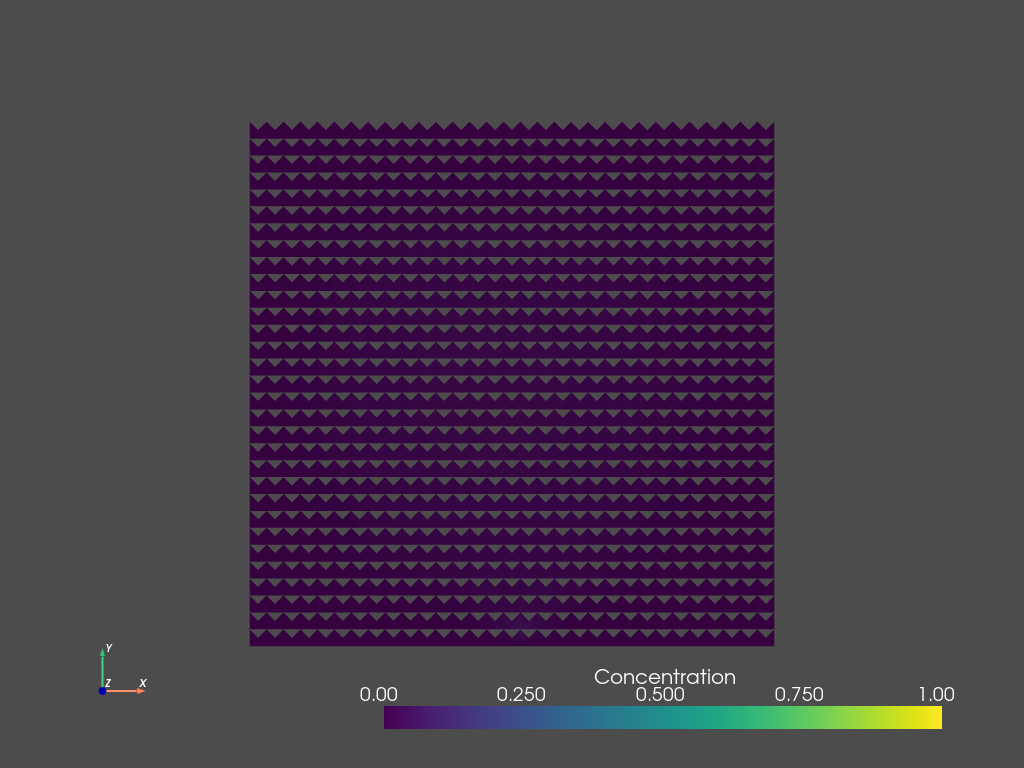

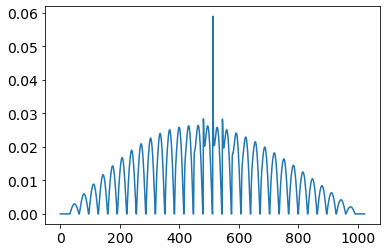

In [54]:
#pn.extension('vtk') 
mesh.point_data = {'Concentration': combined_values}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='surface', jupyter_backend='static')
plt.plot(combined_values[:])